In [67]:
# ! conda install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import PIL
import tensorflow as tf
import tensorflow.keras.layers as tfl
import time

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
# from tensorbay import GAS
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
# import cv
import random
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
# from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split


%matplotlib inline



# 1) Data Preparation

In [74]:
def dataConverter(folder_name, bw=True):
    train_data = []
    image_no = []
    for image in os.listdir(folder_name):
        if bw == True:
            img_array = np.asarray(PIL.Image.open(f'{folder_name}/{image}').convert("L"))
        else:
            img_array = np.asarray(PIL.Image.open(f'{folder_name}/{image}'))
        train_data.append(img_array)
        image_no.append(int(image[:-4]))
    return(np.array(train_data), image_no)

train_data, image_no = dataConverter('train_val')
train_data = train_data.reshape(*(train_data.shape+(1,)))
    
#     img = PIL.Image.open(f'train_val/{image}').convert("L")
#     img.show()

In [48]:
num_df = pd.DataFrame({'image_index':image_no})
cat_df = pd.read_csv('train_val.csv')
final_df = pd.merge(num_df, cat_df, on='image_index', how='inner')
print(num_df)
print(final_df)

     image_index
0            992
1            331
2            477
3            254
4            319
..           ...
995          467
996          451
997          526
998           55
999          763

[1000 rows x 1 columns]
     image_index              type
0            992          dot_line
1            331  hbar_categorical
2            477              line
3            254  hbar_categorical
4            319  hbar_categorical
..           ...               ...
995          467              line
996          451              line
997          526              line
998           55  vbar_categorical
999          763               pie

[1000 rows x 2 columns]


In [63]:
# Converting categorical lables into binary array.
lb = LabelBinarizer()
y = lb.fit_transform(final_df.type)
print(lb.classes_)
print(y, y.shape)
print(train_data.shape)

['dot_line' 'hbar_categorical' 'line' 'pie' 'vbar_categorical']
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 ...
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]] (1000, 5)
(1000, 128, 128, 1)


In [50]:
# Splitting data into train and validation sets.
train_idx = random.sample(range(1000), 850)
val_idx = np.array([i for i in range(1000) if i not in train_idx])

# Creating Normalized train and validation Sets.
x_train = train_data[train_idx,:]/255.0
x_val = train_data[val_idx,:]/255.0
y_train = y[train_idx,:]
y_val = y[val_idx,:]

# 2) Model Creation

In [51]:
def model1(input_shape):
    ''' input shape -> tuple(pixcel, pixcel, channels) '''
    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4,4), strides=(1,1), padding = 'same')(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8, 8), strides=None, padding='same')(A1)
    Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding = 'same')(P1)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=None, padding='same')(A2)
    F = tf.keras.layers.Flatten()(P2)
    D1 = tf.keras.layers.Dense(32, activation="relu")(F)
    outputs = tf.keras.layers.Dense(5 ,activation="softmax")(D1)

    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [52]:
model1 = model1((128,128,1))
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 8)       136       
                                                                 
 re_lu_6 (ReLU)              (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 16)        528       
                                                                 
 re_lu_7 (ReLU)              (None, 16, 16, 16)        0         
                                                           

In [53]:
# Compiling model
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])
# Training the model
epochs = 20
batch_size = 28
history = model1.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))
# Saving model
model1.save("output/model1.h5")

Epoch 1/20
31/31 [==============================] - 2s 45ms/step - loss: 1.6016 - accuracy: 0.2200 - val_loss: 1.5784 - val_accuracy: 0.3267
Epoch 2/20
31/31 [==============================] - 1s 40ms/step - loss: 1.5738 - accuracy: 0.4059 - val_loss: 1.5450 - val_accuracy: 0.5267
Epoch 3/20
31/31 [==============================] - 1s 48ms/step - loss: 1.5299 - accuracy: 0.3588 - val_loss: 1.4836 - val_accuracy: 0.5667
Epoch 4/20
31/31 [==============================] - 1s 41ms/step - loss: 1.4435 - accuracy: 0.6341 - val_loss: 1.3623 - val_accuracy: 0.7667
Epoch 5/20
31/31 [==============================] - 1s 41ms/step - loss: 1.2914 - accuracy: 0.7929 - val_loss: 1.1824 - val_accuracy: 0.7267
Epoch 6/20
31/31 [==============================] - 1s 41ms/step - loss: 1.0752 - accuracy: 0.8588 - val_loss: 0.9538 - val_accuracy: 0.8600
Epoch 7/20
31/31 [==============================] - 1s 41ms/step - loss: 0.8698 - accuracy: 0.8518 - val_loss: 0.7773 - val_accuracy: 0.8400
Epoch 8/20
31

# 3) Visualizing the model training and loss history.

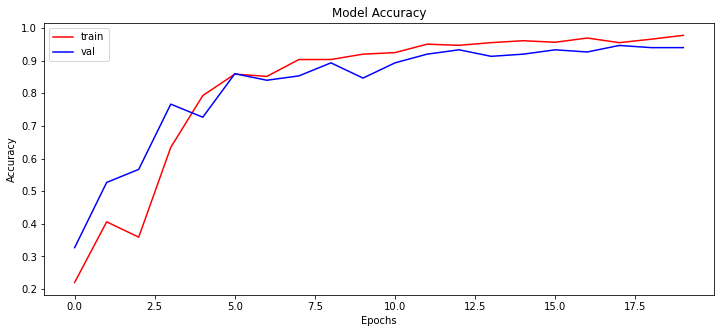

In [54]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

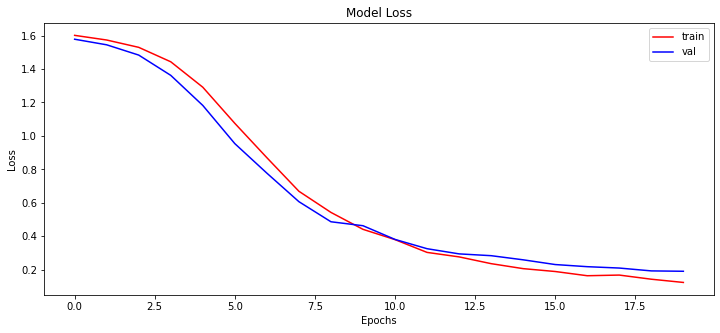

In [55]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

# 4) Comparing the results.

In [75]:
# Converting Test data to Proper Format.
test_data, image_no = dataConverter('test')
test_data = np.array(test_data).reshape(*(test_data.shape+(1,)))
x_test = test_data/255
x_test.shape

(50, 128, 128, 1)

2/2 [==============================] - 0s 11ms/step
vbar_categorical


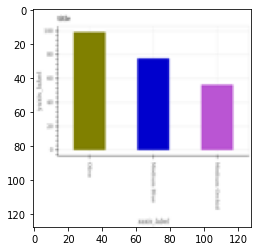

vbar_categorical


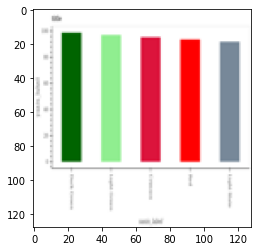

line


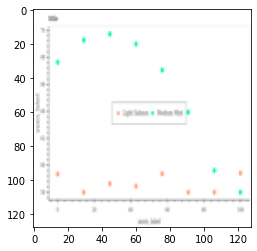

line


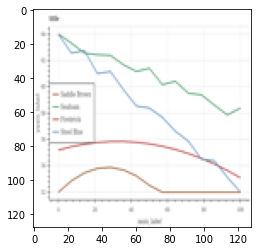

hbar_categorical


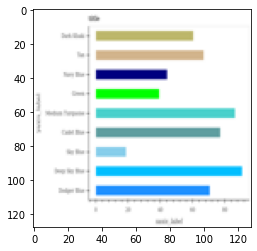

line


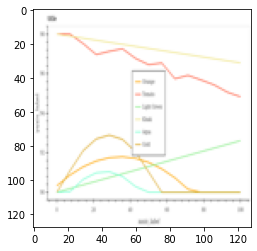

hbar_categorical


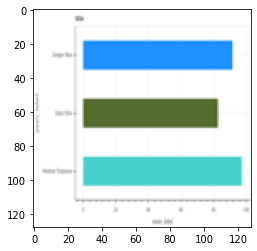

pie


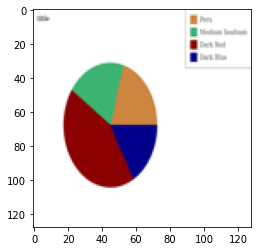

hbar_categorical


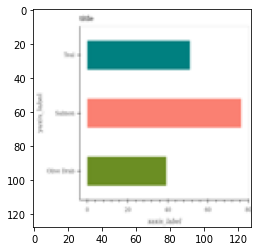

line


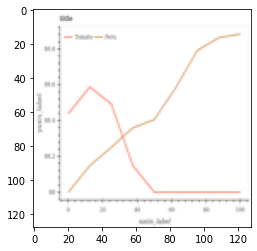

hbar_categorical


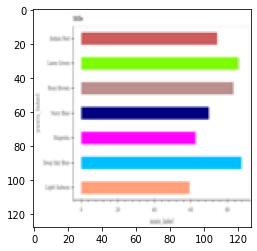

dot_line


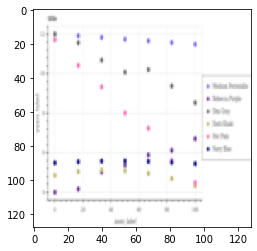

hbar_categorical


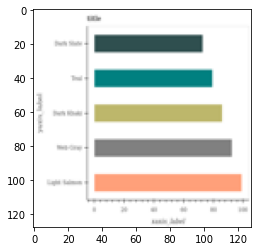

dot_line


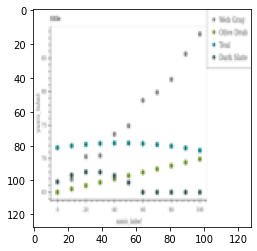

pie


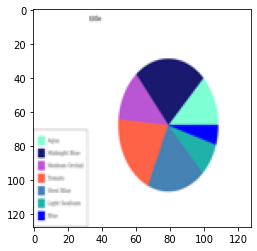

pie


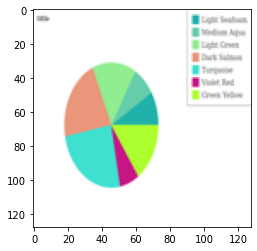

pie


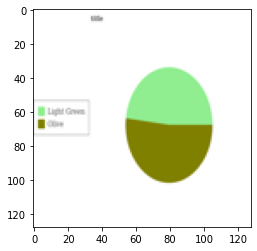

pie


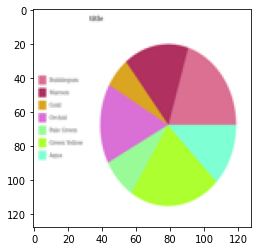

line


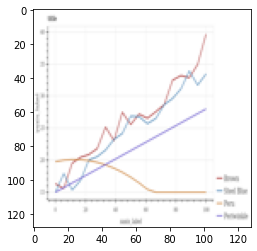

hbar_categorical


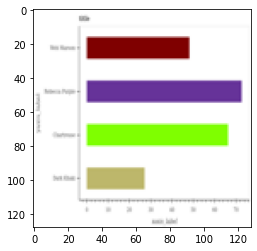

vbar_categorical


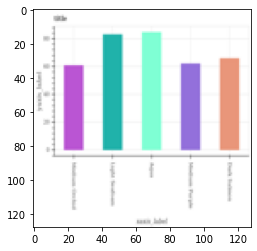

hbar_categorical


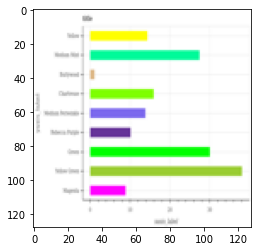

hbar_categorical


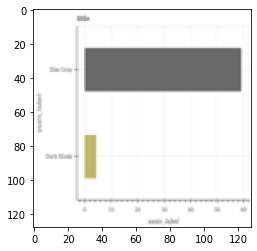

hbar_categorical


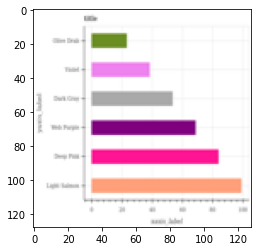

vbar_categorical


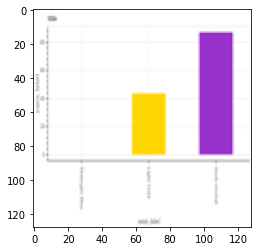

line


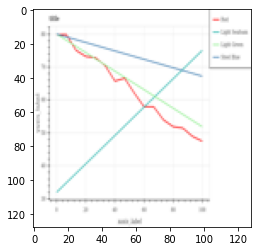

hbar_categorical


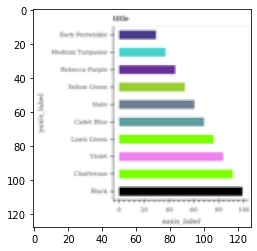

line


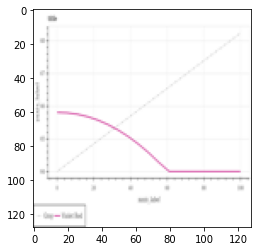

vbar_categorical


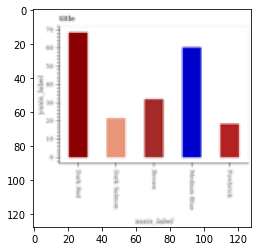

vbar_categorical


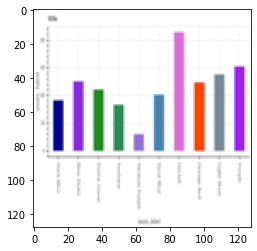

pie


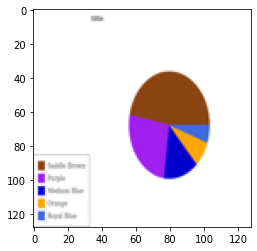

line


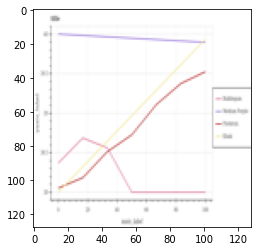

pie


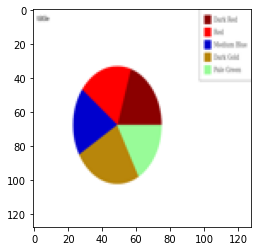

vbar_categorical


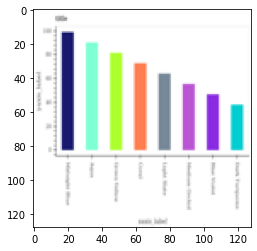

dot_line


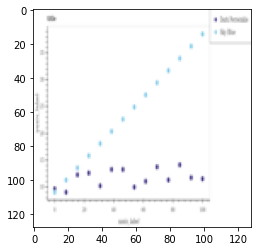

hbar_categorical


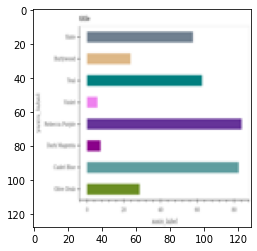

line


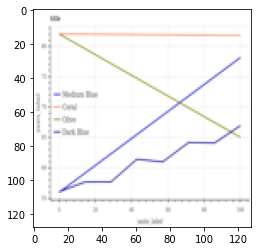

vbar_categorical


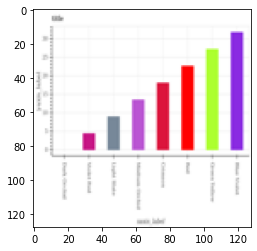

hbar_categorical


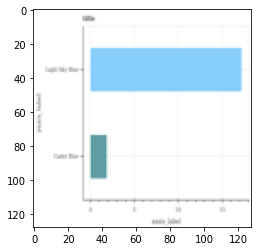

dot_line


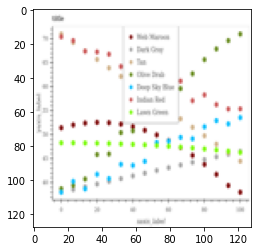

line


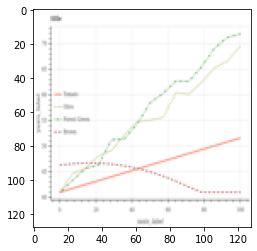

pie


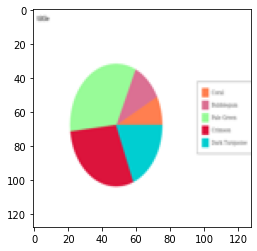

vbar_categorical


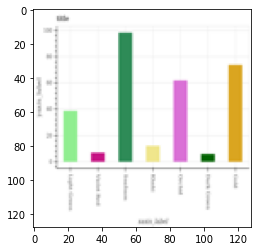

vbar_categorical


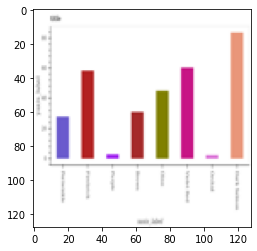

dot_line


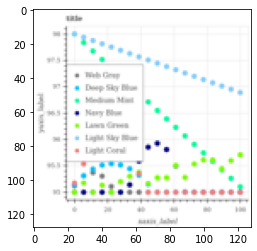

line


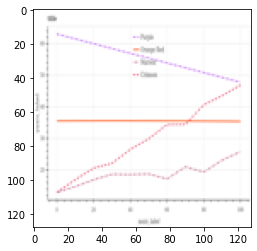

pie


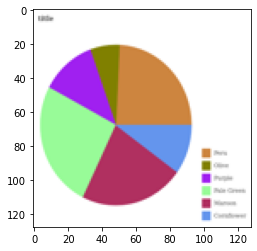

line


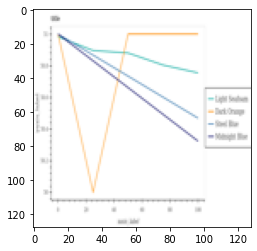

dot_line


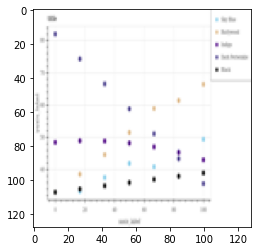

dot_line


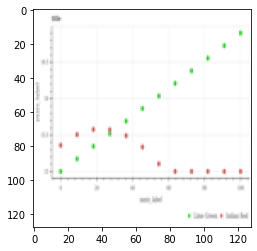

In [77]:
# Storing predictions
inp_test_array,_ = dataConverter('test', bw=False)
y_pred = model1.predict(x_test)
# print(y_pred)

# Finding max value from prediction list.
y_result = []
labels = lb.classes_
# print(labels)
for pred in y_pred:
    y_result.append(labels[np.argmax(pred)])

# Plotting image to compare
for i in range(len(y_pred)):
    print(y_result[i])
    plt.imshow(inp_test_array[i,:,:,:], cmap='gray')
    plt.show()


# img = array_to_img(x_test[4,:,:,1]*255)
# img

In [ ]:
BATCH_SIZE = 15
IMG_SIZE = (128, 128)
directory = "train_val"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)